## Code produit avec l'article: 
https://medium.com/h7w/implementing-a-variational-autoencoder-with-keras-e19d7140ad90

### Implémentation des valeurs de shapley

In [15]:
from keras.layers import Conv1D, Conv2D, Input, Flatten, Dense, MaxPooling1D, MaxPooling2D, BatchNormalization, Concatenate
from keras.optimizers import Adam
from keras import layers
import matplotlib.pyplot as plt
from keras.models import Model
import tensorflow as tf
from PIL import Image
import copy
import numpy as np
import keras
import os
import re



In [16]:
# Fonction pour calculer les coordonées stéréographiques

def stereo(theta, phi):
    x = np.sin(theta) * np.cos(phi)
    y = np.sin(theta) * np.sin(phi)
    z = np.cos(theta)

    # Projection sur x y
    px = x / (1 + z + 1e-8)
    py = y / (1 + z + 1e-8)
    return px, py

# Importation des images

In [17]:
# Dossier contenant les images
repertoire = "../Render/captures"
img_width, img_height = 50, 50

# Expression pour extraire les infos du nom de fichier
#pattern = re.compile(r"img_tv(\d+)_pv(\d+)_tl(\d+)_pl(\d+)\.png") #all
pattern = re.compile(r"img_tv0_pv0_tl(\d+)_pl(\d+)\.jpg") #les images avec tv = 45 (la latitude moyenne)

# Stockage des résultats
images_info = []

for nom_fichier in os.listdir(repertoire):
    if nom_fichier.endswith(".jpg"):
        match = pattern.match(nom_fichier)
        if match:
            tl, pl = match.groups()
            tl, pl = int(tl), int(pl)
            px, py = stereo(np.radians(tl), np.radians(pl)) # Calcul des coordonnées stéréo
            chemin_image = os.path.join(repertoire, nom_fichier)
            image = Image.open(chemin_image)
            w, h = image.size
            left = (w - img_width) / 2
            top = (h - img_height) / 2
            right = (w + img_width) / 2
            bottom = (h + img_height) / 2
            #left, top, right, bottom = int(left), int(top), int(right), int(bottom)
            image = Image.open(chemin_image).crop((left, top, right, bottom))
            pixels = np.array(image, dtype=np.float32) / 255.0


            images_info.append({
                "tl": tl,
                "pl": pl,
                "px": px,
                "py": py,
                "image": image,
                "pixels": pixels,
            })

# Exemple : affichage d'une info
for info in images_info[:5]:  # juste les 5 premières
    print(f"tl={info['tl']}, pl={info['pl']}, px={info['px']}, py={info['py']}")

tl=75, pl=345, px=0.7411809490095723, py=-0.198598836732448
tl=75, pl=225, px=-0.5425821122771244, py=-0.5425821122771243
tl=60, pl=252, px=-0.17841104369713806, py=-0.5490927320369364
tl=30, pl=120, px=-0.13397459549759358, py=0.23205080632532074
tl=45, pl=160, px=-0.3892334257113643, py=0.14166938114040184


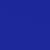

In [18]:
images_info[2]['image']

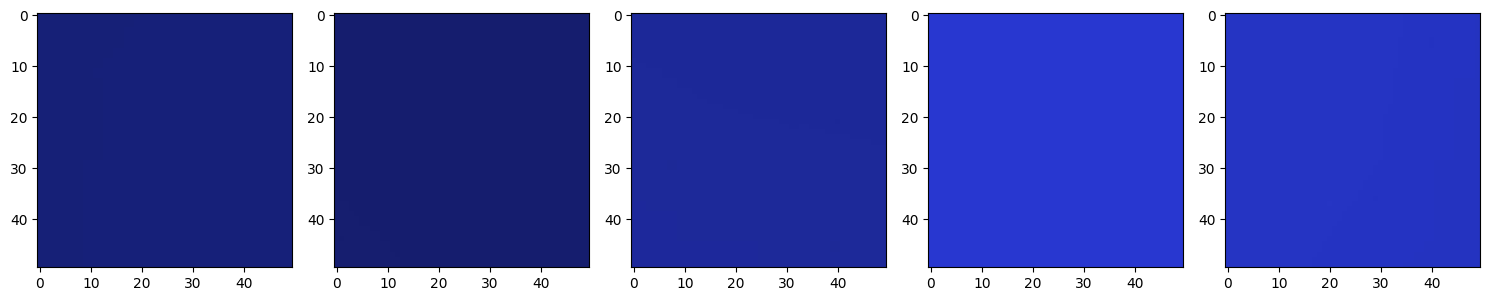

In [19]:
fig, axes = plt.subplots(1, 5, figsize=(15, 5))
for i in range(5): axes[i].imshow(images_info[i]['pixels'])
plt.tight_layout()
plt.show()

# On trie la liste

In [20]:
sorted = copy.deepcopy(images_info)
sorted.sort(key=lambda d: (d["tl"], d["pl"]))

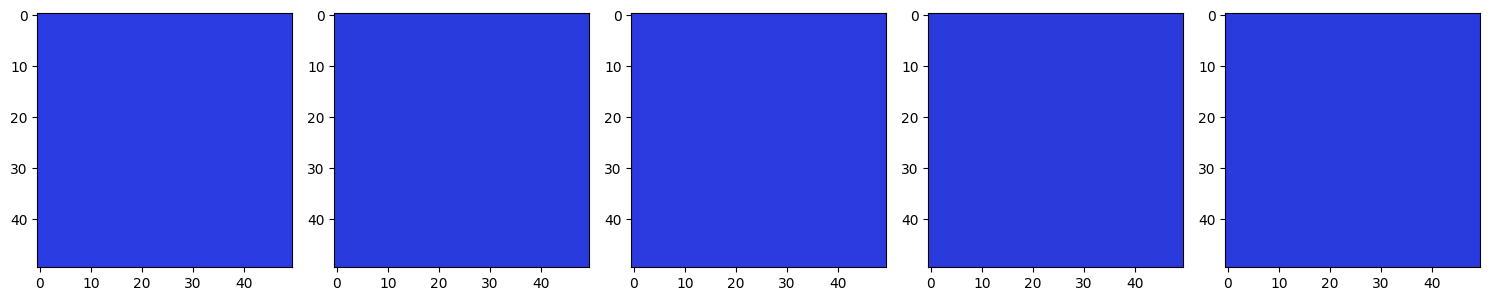

In [21]:
fig, axes = plt.subplots(1, 5, figsize=(15, 5))
for i in range(5): axes[i].imshow(sorted[i]['pixels'])
plt.tight_layout()
plt.show()

# Cette fois ci visualisation de l'oraganisation des texels en fonctin des positions stéréo

In [22]:
# On prend le pixel le plus au centre
texel_row = img_height // 2
texel_col = img_width // 2
texel_position_str = f"({texel_row}, {texel_col})" # Pour l'affichage
print(texel_position_str)

(25, 25)


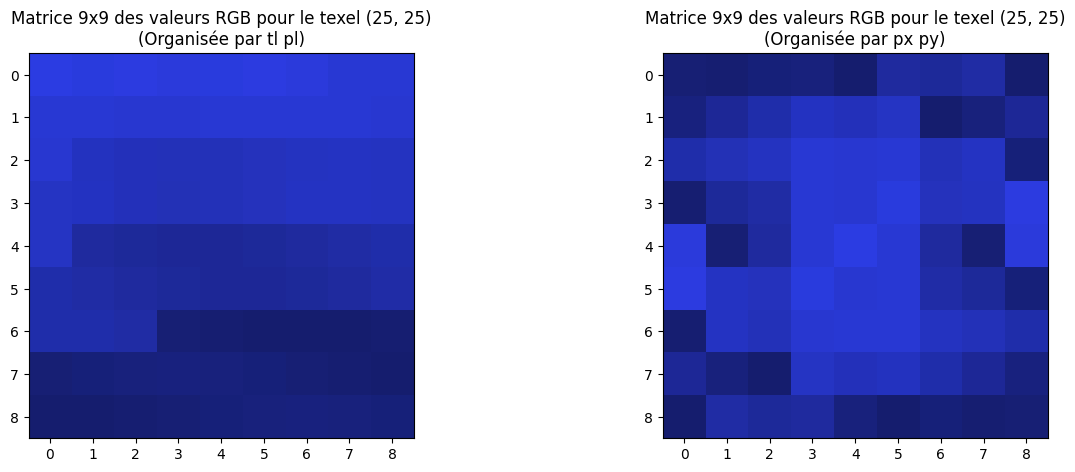

In [23]:
# Visualiser l'organisation de la matrice 9*9 en fonction du tri
# D'abord tl pl puis px, py
texel_angles = []
texel_stereo = []

images_angles = copy.deepcopy(images_info) # Copie pour le tri par angles
images_stereo = copy.deepcopy(images_info) # Copie pour le tri par stéréographiques


# Appliquer les tris aux copies distinctes
images_angles.sort(key=lambda d: (d["tl"], d["pl"]))
images_stereo.sort(key=lambda d: (d["px"], d["py"]))


for ang, ste in zip(images_angles, images_stereo):
    # info["pixels"] est le tableau NumPy 30x30x3 pour l'image entière de cette configuration angulaire
    texel_rgb_a = ang["pixels"][texel_row, texel_col, :]
    texel_rgb_s = ste["pixels"][texel_row, texel_col, :]
    texel_angles.append(texel_rgb_a)
    texel_stereo.append(texel_rgb_s)

# Convertir la liste en tableau NumPy
texel_angles_np = np.array(texel_angles, dtype=np.float32) # Forme (81, 3)
texel_stereo_np = np.array(texel_stereo, dtype=np.float32) # Forme (81, 3)

# Remodeler en matrice 9x9x3
mat_a = (texel_angles_np * 255.0).clip(0, 255).reshape((9, 9, 3)).astype(np.uint8)
mat_s = (texel_stereo_np * 255.0).clip(0, 255).reshape((9, 9, 3)).astype(np.uint8)

fig, axes = plt.subplots(1, 2, figsize=(15, 5))
axes[0].imshow(mat_a)
axes[1].imshow(mat_s)
axes[0].set_title(f"Matrice 9x9 des valeurs RGB pour le texel {texel_position_str}\n(Organisée par tl pl)")
axes[1].set_title(f"Matrice 9x9 des valeurs RGB pour le texel {texel_position_str}\n(Organisée par px py)")
plt.show()


In [24]:
images_info[0]['pixels'][0, 0]

array([0.08627451, 0.1254902 , 0.46666667], dtype=float32)

In [25]:
print("Premier pixel de la troisième image (R,G,B) :", images_info[2]['pixels'][0][0])
print("Nombre d'images importées:", len(images_info))

Premier pixel de la troisième image (R,G,B) : [0.10980392 0.15686275 0.59607846]
Nombre d'images importées: 81


# Création du modèles

In [26]:
latent_dim = 8 # Dimension du bottleneck
num_channels = 3 # RGB
samples = len(images_info) # Nombre de configuration angulaires
matrix_H = 9
matrix_W = 9

input_shape = (matrix_H, matrix_W, num_channels)

# Definition
i = Input(shape=input_shape, name='encoder_input')

# Bloc 1 (Conv1D -> Conv2D, MaxPooling1D -> MaxPooling2D)
x = Conv2D(filters = 64, kernel_size=(3, 3), padding='same', activation='relu')(i)
x = BatchNormalization()(x) #weight decay
x = MaxPooling2D(pool_size=(2, 2))(x)

# Projection
x = Flatten()(x)
latent_output = Dense(latent_dim, name='latent_output')(x)

# Modèle
encoder_model_light = Model(inputs=i, outputs=latent_output, name="EncoderLight")
encoder_model_light.summary()

Model: "EncoderLight"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ encoder_input (InputLayer)      │ (None, 9, 9, 3)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 9, 9, 64)       │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 9, 9, 64)       │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 4, 4, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ latent_output (Dense)           │ (None, 8)              │         8,200 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 10,248 (40.03 KB)

 Trainable params: 10,120 (39.53 KB)

 Non-trainable params: 128 (512.00 B)

In [27]:
# =================
# Decoder
# =================

# Paramètres
angle_dim = 2  # 2 pour lumière
input_dim = latent_dim + angle_dim  # 8 + 2 = 10

# Entrée
decoder_input = Input(shape=(input_dim,), name='decoder_input')

# 4 couches Fully Connected avec ReLU
x = Dense(106, activation='relu')(decoder_input)

x = Dense(106, activation='relu')(x)
x = Dense(106, activation='relu')(x)
x = Dense(106, activation='relu')(x)

# Sortie RGB (3 valeurs)
decoder_output = Dense(3, activation='linear', name='rgb_output')(x)

# Modèle
decoder_model = Model(inputs=decoder_input, outputs=decoder_output, name="Decoder")
decoder_model.summary()

Model: "Decoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ decoder_input (InputLayer)      │ (None, 10)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 106)            │         1,166 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 106)            │        11,342 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 106)            │        11,342 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 106)            │        11,342 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rgb_output (Dense)              │ (None, 3)              │           321 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 35,513 (138.72 KB)

 Trainable params: 35,513 (138.72 KB)

 Non-trainable params: 0 (0.00 B)

In [28]:
# =================
# VAE
# =================
view_light_input = Input(shape=(angle_dim,), name='view_light_input')
latent_vector = encoder_model_light(i)
decoder_input = Concatenate()([latent_vector, view_light_input])
vae_outputs = decoder_model(decoder_input)

vae = Model(inputs=[i, view_light_input], outputs=vae_outputs, name='VAE')
vae.summary()

Model: "VAE"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ encoder_input       │ (None, 9, 9, 3)   │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ EncoderLight        │ (None, 8)         │     10,248 │ encoder_input[0]… │
│ (Functional)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ view_light_input    │ (None, 2)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 10)        │          0 │ EncoderLight[0][… │
│ (Concatenate)       │                   │            │ view_light_input… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Decoder             │ (None, 3)         │     35,513 │ concatenate[0][0] │
│ (Functional)        │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 45,761 (178.75 KB)

 Trainable params: 45,633 (178.25 KB)

 Non-trainable params: 128 (512.00 B)

In [29]:
# --- L2 Loss ---
def custom_reconstruction_loss(y_true, y_pred):
    return tf.reduce_mean(tf.square(y_true - y_pred))


In [30]:
decoder_weights_path = os.path.join('modeles/', 'my_decoder.weights.h5')
decoder_model.save_weights(decoder_weights_path)
print(f"Poids de l'Encodeur sauvegardés à : {decoder_weights_path}")

Poids de l'Encodeur sauvegardés à : modeles/my_decoder.weights.h5


# Compilation et entraînement
Sur un seul texel pour commencer

In [31]:
# on prend toutes les images
image_stack = np.stack([info["pixels"] for info in images_info], axis=0)
# image_stack.shape = (N_images, height, width, 3)

In [32]:
# on fait de même avec les angles
tl_stack = np.stack([info["tl"] for info in images_info], axis=0)
pl_stack = np.stack([info["pl"] for info in images_info], axis=0)

# et pour les positions stéréo
px_stack = np.stack([info["px"] for info in images_info], axis=0)
py_stack = np.stack([info["py"] for info in images_info], axis=0)

In [33]:
# Préparation des données

# Choisir UN texel
texel_position = (0, 0)
texel_observations = image_stack[:, texel_position[0], texel_position[1]] # (samples, num_channels) ex: (81, 3)

padded_observations = np.zeros((matrix_H * matrix_W, num_channels))
padded_observations[:len(texel_observations)] = texel_observations

input_train_batch_2d = padded_observations.reshape((1, matrix_H, matrix_W, num_channels))
target_rgb_train = texel_observations  # (81, 3)
light_dirs = np.stack([px_stack, py_stack], axis=1) # Forme (81, 2)

In [36]:
input_train_batch_2d.shape

(1, 9, 9, 3)

# Pre train avant d'utiliser les valeurs de shapley

In [87]:
custom_optimizer = Adam(learning_rate=0.01) # Adam est une version améliorée de la descente de gradient stochastique, par défaut on avait 0.001
vae.compile(custom_optimizer, loss=lambda y_true, y_pred: custom_reconstruction_loss(y_true, y_pred))

history_vae = vae.fit([np.repeat(input_train_batch_2d, samples, axis=0), light_dirs], target_rgb_train,
        epochs=50, batch_size=5, validation_split=0.2)

Epoch 1/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.2132 - val_loss: 0.0356
Epoch 2/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0136 - val_loss: 0.0303
Epoch 3/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0130 - val_loss: 0.0169
Epoch 4/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0106 - val_loss: 0.0144
Epoch 5/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0126 - val_loss: 0.0076
Epoch 6/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0102 - val_loss: 0.0075
Epoch 7/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0067 - val_loss: 0.0072
Epoch 8/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0074 - val_loss: 0.0066
Epoch 9/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0065 - val_loss: 0.0136
Epoch 10/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0137 - val_loss: 0.0064
Epoch 11/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0079 - val_loss: 0.0065
Epoch 12/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0067 - val_l

dict_keys(['loss', 'val_loss'])


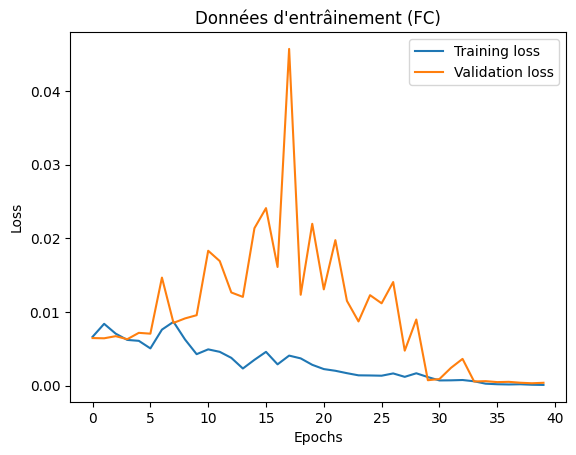

In [88]:
# Evaluer l'apprentissage d'un modèle --Code: Patrick Reuter--
def montrerCourbesApprentissage(history):
    #list all data in history
    print(history.history.keys())

    plt.plot(history.history['loss'][10:], label="Training loss")
    plt.plot(history.history['val_loss'][10:], label="Validation loss")

    plt.title("Données d'entrâinement (FC)")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()

montrerCourbesApprentissage(history_vae)

# Visualisation des poids

In [99]:
vae_save_path = os.path.join('modeles/', 'my_vae_model.h5')
vae.save(vae_save_path)
print(f"Modèle vae sauvegardé à : {vae_save_path}")


deco_save_path = os.path.join('modeles/', 'my_deco_model.h5')
decoder_model.save(deco_save_path)
print(f"Modèle deco sauvegardé à : {deco_save_path}")

decoder_weights_path = os.path.join('modeles/', 'my_decoder_after.weights.h5')
decoder_model.save_weights(decoder_weights_path)
print(f"Poids de l'Encodeur sauvegardés à : {decoder_weights_path}")

Modèle vae sauvegardé à : modeles/my_vae_model.h5
Modèle deco sauvegardé à : modeles/my_deco_model.h5
Poids de l'Encodeur sauvegardés à : modeles/my_decoder_after.weights.h5


In [90]:
# On recharge le modèle

loaded_deco_model = keras.models.load_model(deco_save_path)
print(f"Modèle chargé avec succès depuis : {deco_save_path}")


# Chargez les poids dans le modèle recréé
decoder_weights_path = os.path.join('modeles/', 'my_decoder_after.weights.h5')
loaded_deco_model.load_weights(decoder_weights_path)
print(f"Poids chargés avec succès depuis : {decoder_weights_path}")

print("\n--- Visualisation des poids ---")

# Itérer sur les couches du modèle et afficher les poids
for idx, layer in enumerate(loaded_deco_model.layers):
    # Seules les couches ayant des poids entraîneront `len(layer.get_weights()) > 0`
    if len(layer.get_weights()) > 0:
        # Obtenir la forme de sortie de la couche
        # layer.output_shape est la méthode recommandée, mais si elle échoue, on utilise layer.output.shape
        current_output_shape = "N/A" 
        try:
            current_output_shape = layer.output_shape
        except AttributeError:
            if hasattr(layer, 'output') and hasattr(layer.output, 'shape'):
                current_output_shape = layer.output.shape
            else:
                current_output_shape = "Forme non trouvée"

        print(f"\nCouche {idx}: {layer.name} (Forme de sortie: {current_output_shape})")
        weights = layer.get_weights() # get_weights() retourne une liste de tensors de poids

        # Gérer les couches Conv2D et Dense (poids + biais)
        if isinstance(layer, layers.Conv2D) or isinstance(layer, layers.Dense):
            if len(weights) >= 2: # Devrait être [kernel, bias]
                kernel_weights = weights[0]
                bias_weights = weights[1]

                print(f"  Forme des poids (kernel) : {kernel_weights.shape}")
                print(f"  Quelques valeurs de poids (kernel) :\n{kernel_weights.flatten()[:10]}")
                print(f"  Min/Max des poids (kernel) : {kernel_weights.min():.4f} / {kernel_weights.max():.4f}")

                print(f"  Forme des biais : {bias_weights.shape}")
                print(f"  Quelques valeurs de biais :\n{bias_weights.flatten()[:10]}")
                print(f"  Min/Max des biais : {bias_weights.min():.4f} / {bias_weights.max():.4f}")
            else:
                print(f"  Couche {layer.name} ({type(layer).__name__}) a un nombre inattendu de tensors de poids: {len(weights)}")

        # Gérer les couches BatchNormalization (gamma, beta, moving_mean, moving_variance)
        elif isinstance(layer, layers.BatchNormalization):
            if len(weights) == 4: # Les couches BN ont 4 tensors de poids
                gamma, beta, moving_mean, moving_variance = weights
                print(f"  Forme des poids (gamma) : {gamma.shape}")
                print(f"  Quelques valeurs de gamma :\n{gamma.flatten()[:10]}")
                print(f"  Forme des biais (beta) : {beta.shape}")
                print(f"  Quelques valeurs de beta :\n{beta.flatten()[:10]}")
                print(f"  Forme du moving_mean : {moving_mean.shape}")
                print(f"  Forme du moving_variance : {moving_variance.shape}")
            else:
                print(f"  Couche BatchNormalization a un nombre inattendu de tensors de poids: {len(weights)}")

        # Gérer d'autres types de couches avec des poids
        else:
            print(f"  Couche {layer.name} de type {type(layer).__name__} a des poids mais n'est pas gérée explicitement pour l'affichage détaillé.")
            if len(weights) > 0:
                print(f"  Forme du premier poids : {weights[0].shape}")
                print(f"  Quelques valeurs du premier poids :\n{weights[0].flatten()[:10]}")


Modèle chargé avec succès depuis : modeles/my_deco_model.h5
Poids chargés avec succès depuis : modeles/my_decoder_after.weights.h5

--- Visualisation des poids ---

Couche 1: dense_8 (Forme de sortie: (None, 106))
  Forme des poids (kernel) : (10, 106)
  Quelques valeurs de poids (kernel) :
[ 0.09501185  0.10936406  0.09452678 -0.06606217 -0.10153387 -0.01205525
  0.2179694   0.18069567  0.24497475  0.14019461]
  Min/Max des poids (kernel) : -1.4960 / 1.2868
  Forme des biais : (106,)
  Quelques valeurs de biais :
[ 0.14386198  0.08749412 -0.06269968  0.03254174 -0.07296364 -0.09749016
 -0.11693988 -0.084983   -0.11600564  0.06002454]
  Min/Max des biais : -0.2134 / 0.1830

Couche 2: dense_9 (Forme de sortie: (None, 106))
  Forme des poids (kernel) : (106, 106)
  Quelques valeurs de poids (kernel) :
[ 0.06417867 -0.18068303 -0.01133376 -0.07206871  0.04647163  0.16173954
  0.00151078 -0.22484866 -0.05047499 -0.23627564]
  Min/Max des poids (kernel) : -0.8141 / 0.4561
  Forme des biais 

# Application des valeurs de shapley

In [91]:
def approximate_shapley_values_for_latent(
    decoder_model,
    latent_vector_instance, # Le vecteur latent (8,) pour lequel on veut les Shapley values
    light_direction_instance, # La direction de lumière (2,) à utiliser
    num_samples=1000,         # Nombre d'échantillons de coalitions pour l'approximation
    output_dim=3              # Dimension de la sortie du décodeur (e.g., 3 pour RGB)
):
    n = len(latent_vector_instance) # Nombre de dimensions latentes
    shapley_values = np.zeros(n)

    # Convertir en TensorFlow Tensors si ce n'est pas déjà fait
    latent_vector_instance_tf = tf.constant(latent_vector_instance, dtype=tf.float32)
    light_direction_instance_tf = tf.constant(light_direction_instance, dtype=tf.float32)

    # Valeur de référence (baseline): prédiction avec un vecteur latent "nul" (ici, zéro)
    # Assurez-vous que le "zéro" a le même sens que l'espace latent (souvent le milieu de l'espace)
    baseline_latent_vector = tf.zeros_like(latent_vector_instance_tf)

    for i in range(n): # Itérer sur chaque dimension latente (le "joueur" z_i)
        marginal_contributions = []

        for _ in range(num_samples): # Échantillonner des coalitions
            # Choisir une taille de coalition j aléatoirement
            j = np.random.randint(0, n) # Taille du sous-ensemble S, peut aller de 0 à n-1

            # Créer une coalition S aléatoire de taille j qui n'inclut PAS la feature i
            available_features = [f for f in range(n) if f != i]
            np.random.shuffle(available_features)
            
            # S est la coalition des features déjà présentes (hors i)
            # La taille de S doit être j, donc on prend les j premiers de available_features
            current_coalition_S_indices = sorted(available_features[:j])

            # Construire z_S : vecteur latent où seules les features de S sont présentes
            z_S = tf.identity(baseline_latent_vector) # Copie du vecteur de référence
            for idx in current_coalition_S_indices:
                z_S = tf.tensor_scatter_nd_update(z_S, [[idx]], [latent_vector_instance_tf[idx]])

            # Construire z_S_plus_i : vecteur latent où les features de S ET la feature i sont présentes
            z_S_plus_i = tf.tensor_scatter_nd_update(z_S, [[i]], [latent_vector_instance_tf[i]])

            # --- Prédictions ---
            # Input pour d(z_S)
            input_S = tf.concat([z_S, light_direction_instance_tf], axis=0)
            prediction_S = decoder_model.predict(tf.expand_dims(input_S, axis=0), verbose=0)[0]

            # Input pour d(z_S U {i})
            input_S_plus_i = tf.concat([z_S_plus_i, light_direction_instance_tf], axis=0)
            prediction_S_plus_i = decoder_model.predict(tf.expand_dims(input_S_plus_i, axis=0), verbose=0)[0]

            # Calculer la contribution marginale absolue de la feature i pour cette coalition
            # Comme spécifié dans le papier : |E[d(zS∪{i})]− E[d(zS )]|
            # Et si la sortie a plus d'une dimension (RGB), on somme sur les dimensions de sortie
            diff_componentwise = tf.abs(prediction_S_plus_i - prediction_S)
            marginal_contribution = tf.reduce_sum(diff_componentwise) # Somme sur les dimensions RGB

            marginal_contributions.append(marginal_contribution.numpy())

        # La valeur de Shapley approximée est la moyenne de ces contributions marginales
        shapley_values[i] = np.mean(marginal_contributions)

    return shapley_values

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
Calcul des valeurs de Shapley pour le vecteur latent : [-0.7279474   0.558353    0.18501323 -0.31218255 -1.3570354   0.3713091
 -0.6087455  -0.30218408]
Avec la direction de lumière : [-7.67326982e-01  9.39704532e-17]

Valeurs de Shapley approximées pour chaque dimension latente :
  Dimension 0: 0.0083
  Dimension 1: 0.0174
  Dimension 2: 0.0037
  Dimension 3: 0.0049
  Dimension 4: 0.0438
  Dimension 5: 0.0064
  Dimension 6: 0.0092
  Dimension 7: 0.0051


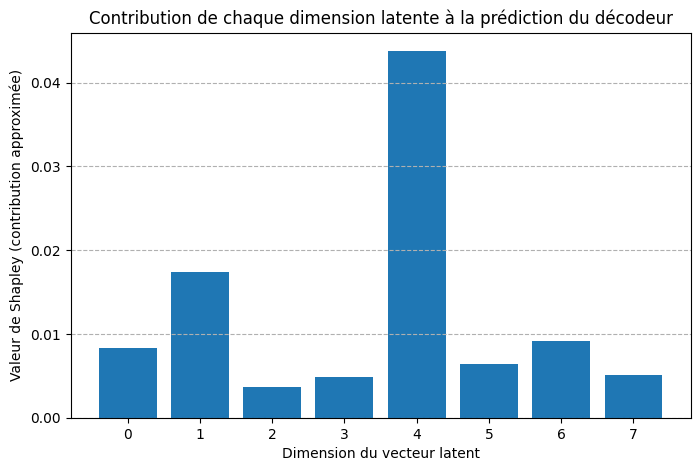

In [92]:
# --- Exemple d'utilisation ---

light_direction =light_dirs[0]
latent_vector = encoder_model_light.predict(input_train_batch_2d)[0]  # (8,)
print(f"Calcul des valeurs de Shapley pour le vecteur latent : {latent_vector}")
print(f"Avec la direction de lumière : {light_direction}")

# Calculer les valeurs de Shapley
# Augmenter num_samples pour une meilleure approximation
approx_shapley_values = approximate_shapley_values_for_latent(
    decoder_model,
    latent_vector,
    light_direction,
    num_samples=500 # Plus de samples = plus précis, plus lent
)

print("\nValeurs de Shapley approximées pour chaque dimension latente :")
for i, val in enumerate(approx_shapley_values):
    print(f"  Dimension {i}: {val:.4f}")

# Visualisation (facultatif)
plt.figure(figsize=(8, 5))
plt.bar(range(latent_dim), approx_shapley_values)
plt.xlabel("Dimension du vecteur latent")
plt.ylabel("Valeur de Shapley (contribution approximée)")
plt.title("Contribution de chaque dimension latente à la prédiction du décodeur")
plt.xticks(range(latent_dim))
plt.grid(axis='y', linestyle='--')
plt.show()

# Prédicitions d'un texel avec toutes les dimensions

In [94]:
index = 3
light_direction =light_dirs[index]

latent_vector = encoder_model_light.predict(input_train_batch_2d)[0]  # (8,)

# Prédire pour une direction spécifique (par exemple view_light_train[0])
decoder_input = np.concatenate([latent_vector, light_direction])[np.newaxis, :]
predicted_rgb = decoder_model.predict(decoder_input)  # (1, 3)
print("Predicted RGB:", predicted_rgb, "Original", target_rgb_train[index])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Predicted RGB: [[0.09377568 0.12621    0.47358304]] Original [0.09411765 0.12941177 0.49411765]


# Enlever les dimensions superflues, et continuer l'entraînement

In [95]:
active_indices = [1, 4] # Inices des dimensions que l'on garde

mask = tf.zeros_like(latent_vector, dtype=tf.float32) # Initialiser un masque de zéros
# Créer les indices pour le scatter_nd_update
indices = tf.constant([[idx] for idx in active_indices], dtype=tf.int32)

# Récupérer les valeurs des dimensions actives
values_to_keep = tf.gather_nd(latent_vector, indices)

# Appliquer les valeurs actives au masque
masked_latent_vector = tf.tensor_scatter_nd_update(mask, indices, values_to_keep)


# Prédicitions d'un texel avec une configuration spécifique

In [96]:

index = 3
light_direction =light_dirs[index]

# Prédire pour une direction spécifique (par exemple view_light_train[0])
decoder_input = np.concatenate([masked_latent_vector, light_direction])[np.newaxis, :]
predicted_rgb = decoder_model.predict(decoder_input)  # (1, 3)
print("Predicted RGB:", predicted_rgb, "Original", target_rgb_train[index])


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
Predicted RGB: [[0.09468169 0.12214936 0.4638825 ]] Original [0.09411765 0.12941177 0.49411765]


In [98]:
masked_latent_vector

<tf.Tensor: shape=(8,), dtype=float32, numpy=
array([ 0.       ,  0.558353 ,  0.       ,  0.       , -1.3570354,
        0.       ,  0.       ,  0.       ], dtype=float32)>